In [ ]:
'''
Prerequisites to download
'''
! pip install sentence_transformers
! pip install umap-learn
! pip install hdbscan
! pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 1.6 MB/s 
     |████████████████████████████████| 5.8 MB 14.4 MB/s 
     |████████████████████████████████| 1.3 MB 24.6 MB/s 
     |████████████████████████████████| 182 kB 39.2 MB/s 
     |████████████████████████████████| 7.6 MB 33.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=b83cc1e1ca0a3857d8fe46559c4640953f666cd663fdb5d618539ef9de6583fd
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.2 MB/s 
     |████████████████████████████████| 1.1 MB 37.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.

In [ ]:
'''
# importing libraries
fetch_20newsgroups -> Dataset imported
SentenceTransformer, umap, hdbscan -> Implement BERT 
CountVectorizer -> Feature extraction
cosine_similarity -> measures similarity between vectors
'''
from sklearn.datasets import fetch_20newsgroups
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import umap
import hdbscan
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def BERT(dataset):
  # importing pre-trained distilbert model from sentence transformer library
  bertModel = SentenceTransformer('distilbert-base-nli-mean-tokens')
  # encoding the model
  encodedModel = bertModel.encode(dataset, show_progress_bar=True)
  # to reduce the issue of high dimentionaly, umap encoding with 5 dimension is used. The number of nearest neighbors can be played with   
  umapEncoding = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine').fit_transform(encodedModel)
  # considering the compatibility of HDBSCAN with umap dimention, the clustering is performed with this algorithm
  # for cluster_selection_method, we have used both eom and leaf. eom extracts the most stable clustering group whereas leaf method selects
  # clusters from the bottom of the leaf
  clusteredGroup = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom').fit(umapEncoding)
  # Preparing the dataset to visualize 
  umappedData = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(encodedModel)
  return umappedData, clusteredGroup

# fetching the dataset from scikit-learn
newsData = fetch_20newsgroups(subset='all')['data']
# ckustering dataset using BERT senternce transformer
mapData, clusters = BERT(newsData)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/589 [00:00<?, ?it/s]

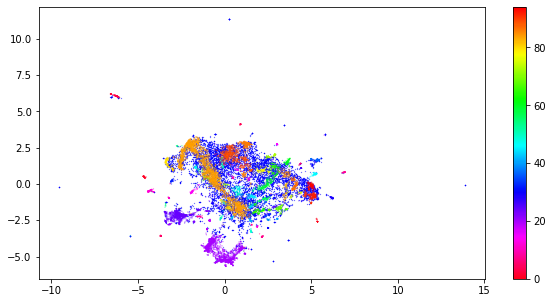

In [ ]:
'''
The clustered groups are visualized in this section.
'''
def displayClusteredDataset(data, cluster):
  df = pd.DataFrame(data, columns=['x', 'y'])
  df['labels'] = cluster.labels_
  fig, ax = plt.subplots(figsize=(10, 5))
  # -1 labels are defined as outliers
  outlierPoints = df.loc[df.labels == -1, :]
  clusteredGroups = df.loc[df.labels != -1, :]
  # outliers are displayed with red color code
  plt.scatter(outlierPoints.x, outlierPoints.y, color='blue', s=0.05)
  plt.scatter(clusteredGroups.x, clusteredGroups.y, c=clusteredGroups.labels, s=0.05, cmap='hsv_r')
  plt.colorbar()

# visualizing the clusters generated by BERT model
displayClusteredDataset(mapData, clusters)

In [ ]:
'''
In this function, the clusters belong to the same group are filtered and the unique topics are generated.
'''
def generateClusterByDocument(newsDataset, cluster):
  # extracting the document column 
  dfDocuments = pd.DataFrame(newsDataset, columns=["Document"])
  # the labels generated by BERT and the document id's are extracted 
  dfDocuments['Topic'] = cluster.labels_
  dfDocuments['Doc_ID'] = range(len(dfDocuments))
  # the topics of same label are accumulated 
  documentsTopic = dfDocuments.groupby(['Topic'], as_index = False).agg({'Document': ' '.join})
  return dfDocuments, documentsTopic

# calling the function to get the dataframe consisting of similar topics
dfDocs, topicsDoc = generateClusterByDocument(newsData, clusters)

In [ ]:
'''
This function calculates the count of each word based on the input parameter of ngram and 
the tf-idf is calculated using the transformation of the two-dimensional count vector
'''
def generateFeatures(news, length, ngram_range=(1, 1)):
    # the CountVectorizer tokenizes the counts to a two-dimesional matrix
    countVec = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(news)
    transformedArray = countVec.transform(news).toarray()
    arraySum = transformedArray.sum(axis=0)
    weights = transformedArray.sum(axis=1)
    # tf and idf is calculated using the formula and multiplied using numpy to generate tf-idf
    tf = np.divide(transformedArray.T, weights)
    idf = np.log(np.divide(length, arraySum)).reshape(-1, 1)
    tfIdf = np.multiply(tf, idf)
    return countVec, tfIdf

countVec, tfIdf = generateFeatures(topicsDoc.Document.values, len(newsData))

In [ ]:
'''
This function derivates the topics that have been frequently found among the given dataset
'''
def getFrequentWords(tfIdf, countVec, docTopics, n=20):
    # a built-in function that extracts the feature names 
    features = countVec.get_feature_names()
    topics = list(docTopics.Topic)
    transposeTfIdf = tfIdf.T
    indices = transposeTfIdf.argsort()[:, -n:]
    # generates the frequent topics and puts it into a dictionary
    freqWords = {topic: [(features[j], transposeTfIdf[i][j]) for j in indices[i]][::-1] for i, topic in enumerate(topics)}
    return freqWords

# n is the number of top words in the clustered dataset
frequentWords = getFrequentWords(tfIdf, countVec, topicsDoc, n=20)

In [ ]:
'''
This function returns the topics by the size and dispays it afterwards
-1 means the number of topics that are unassigned to any groups
'''
def getNumberofTopics(docs):
    totalTopics = (docs.groupby(['Topic']).Document.count().reset_index().rename
                   ({"Topic": "Topic", "Document": "Size"}, axis='columns').sort_values("Size", ascending=False))
    return totalTopics

totalTopics = getNumberofTopics(dfDocs) 
print('Total Number of Topics: ', len(totalTopics))
# the top 10 topics are displayed
totalTopics.head(11)

Total Number of Topics:  96


,Topic,Size
0,-1,8787
85,84,2761
21,20,1578
25,24,854
90,89,614
87,86,262
88,87,155
93,92,147
60,59,125
13,12,115


In [ ]:
'''
This function displays some of the topic words from different clusters
'''
def displayTopClusters(df, topics):
  counter = 0
  for topic in topics:
    if topic != -1:
      print ("Topic %d:" % (counter+1)) # printing the cluster number or topic number
      counter += 1
      print(" ".join([topic for topic, prob in df[topic][:10]]) )
      
displayTopClusters(frequentWords, totalTopics['Topic'][:11])

Topic 1:
dos 00 sale car windows drive thanks software pc graphics
Topic 2:
game team hockey games season players play nhl baseball ca
Topic 3:
nasa space gov henry launch jpl moon orbit earth spacecraft
Topic 4:
windows problem help dos disk thanks error file screen files
Topic 5:
hiv 92 aids pain doctor vitamin pitt medical geb gordon
Topic 6:
atheists keith livesey atheist caltech atheism morality moral schneider sgi
Topic 7:
jesus god christ christian scripture christianity bible faith christians truth
Topic 8:
gun guns militia weapons manes revolver control firearms 000 weapon
Topic 9:
tu dresden inf uni germany informatik beck dortmund hamburg andre_beck
Topic 10:
turkish armenian armenians serdar argic turks genocide armenia soviet zuma


In [ ]:
'''
This function reduces the number of topics and groups similar topics together based on the cosine similary of the tf-idf calculated earlier.
'''
def reduceTopics(dataset, df, tfIdf):
  # using a loop to regenerate the topics and merge the similar ones
  for i in range(20):
      # derives cosine similarity from the tfidf 
      sim = cosine_similarity(tfIdf.T)
      # as the similary of the same document is 0,the diagonal positions are filled with 0
      np.fill_diagonal(sim, 0)

      # total number of topics currently in the dataframe
      numberofTopics = df.groupby(['Topic']).count().sort_values("Document", ascending=False).reset_index()
      # the topic that will be merged 
      mergeTopic = numberofTopics.iloc[-1].Topic
      # the topic with max similarity where the merge will be performed
      mergeIntoTopic = np.argmax(sim[mergeTopic + 1]) - 1

      # Update the dataframe with the merged topic
      df.loc[df.Topic == mergeTopic, "Topic"] = mergeIntoTopic
      prevTopics = df.sort_values("Topic").Topic.unique()
      # map the topic into dictionary
      mappedTopics = {prevTopic: index - 1 for index, prevTopic in enumerate(prevTopics)}
      df.Topic = df.Topic.map(mappedTopics)
      dfTopic = df.groupby(['Topic'], as_index = False).agg({'Document': ' '.join})

      # calculate the tf-idf and count vector based on the merged clusters
      countVec, tfIdf = generateFeatures(dfTopic.Document.values, len(dataset))
      freqWords = getFrequentWords(tfIdf, countVec, dfTopic, n=20)

  # returns the dataframe with merged topics
  return df, freqWords
  

reducedDf, frequentWords = reduceTopics(newsData, dfDocs, tfIdf)
reducedTopicSize = getNumberofTopics(reducedDf) 
# displaying the top topics after performing the topic reduction strategy
print('Reduced Number of Topics: ', len(reducedTopicSize))
reducedTopicSize.head(10)

Reduced Number of Topics:  76


,Topic,Size
0,-1,8787
67,66,2818
20,19,1578
24,23,871
72,71,614
69,68,280
74,73,165
70,69,155
47,46,147
46,45,143


In [ ]:
displayTopClusters(frequentWords, reducedTopicSize['Topic'][:11])

68
Topic 1:
sale dos car 00 windows thanks price card pc drive
Topic 2:
game team hockey games season players play nhl baseball ca
Topic 3:
scsi windows problem dos disk thanks help mac memory program
Topic 4:
nasa space gov henry jpl launch moon spacecraft orbit earth
Topic 5:
apr drive reply article org ide 40 mit 00 nntp
Topic 6:
hiv 92 doctor pitt geb pain gordon aids banks medical
Topic 7:
god jesus christ christian bible heaven faith satan christianity sin
Topic 8:
armenian armenians turkish armenia turks serdar argic azerbaijan soviet genocide
Topic 9:
gun guns militia revolver manes control 000 firearms handgun uic
Topic 10:
church god bible faith jesus christians christian christ belief believe
